In [30]:
import os
import h5py
import pickle
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import binned_statistic
from glob import glob
from tqdm import tqdm
import seaborn as sns

In [31]:
import matplotlib.font_manager
fonts = matplotlib.font_manager.get_font_names()
#fonts = [matplotlib.font_manager.FontProperties(fname=fname).get_name() for fname in flist]
fonts.sort()
for font in fonts:
    #print(font)
    pass

In [32]:
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,  # Enable LaTeX
    'text.latex.preamble': r"\usepackage{amsmath}",
    "font.family": "serif",  # Use serif font (Computer Modern by default)
    "font.serif": ["Computer Modern Roman"],  # Explicitly set to CM
    "axes.unicode_minus": False  # Ensure minus signs render correctly
})

In [33]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "STIX Math"

In [34]:
project_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
plot_dir = os.path.join(project_dir, 'plots')

In [35]:
netws = {'A-Sharp':'LHI', 
         'XG':'CE4020ET123'}

In [36]:
def z_peak_new(gamma, kappa, z_peak):
    new_peak = (gamma/(kappa-gamma))**(1/kappa) * (1+z_peak) - 1
    return(new_peak)

def z_peak_new_from_dict(parameters):
    """
    parameters: dict
    
    Returns
    ------------------
    converted_parameters: dict
    """
    converted_parameters = parameters.copy()
    gamma = parameters['gamma']
    kappa = parameters['kappa']
    z_peak = parameters['z_peak']
    if isinstance(gamma, float):
        if gamma >= kappa:
            converted_parameters['z_peak_new'] = -1
    elif isinstance(gamma, np.ndarray) or isinstance(gamma, list):
        converted_parameters['z_peak_new'] = []
        for i in range(len(gamma)):
            gamma_i = gamma[i]
            kappa_i = kappa[i]
            z_peak_i = z_peak[i]
            if gamma_i >= kappa_i:
                converted_parameters['z_peak_new'].append(-1)
            else:
                converted_parameters['z_peak_new'].append((gamma_i/(kappa_i-gamma_i))**(1/kappa_i) * (1+z_peak_i) - 1)
        converted_parameters = {key:np.array(converted_parameters[key]) for key in converted_parameters.keys()}
    return converted_parameters

In [37]:
true_params = {'MD':{'gamma':1.8032, 'kappa':5.3023, 'z_peak':1.8362}, 
               'MDhigh':{'gamma':1.7982, 'kappa':5.3226, 'z_peak':2.4199},
               'MDlow':{'gamma':1.8111, 'kappa':5.2753, 'z_peak':1.4917}}
for MDmodel in true_params.keys():
    true_params[MDmodel]['z_peak_new'] = z_peak_new(**true_params[MDmodel])

In [40]:
gwpop_run_strs = {'MD':{'Asharp':{'total':'run09', 
                                  'below_40':'run03', 
                                  '40-80':'run02', 
                                  'above_80':'run04'}, 
                        
                        'CE4020ET123':{'total':'run18',
                                       'below_40':'run04',
                                       '40-80':'run02',
                                       'above_80':'run02'}}, 
                  
                  'MDhigh':{'Asharp':{'total':'run10', 
                                      'below_40':'run04', 
                                      '40-80':'run03',
                                      'above_80':'run05'}, 
                            
                            'CE4020ET123':{'total':'run16', 
                                           'below_40':'run05', 
                                           '40-80':'run03', 
                                           'above_80':'run03'}},
                  
                  'MDlow':{'Asharp':{'total':'run11', 
                                     'below_40':'run05',
                                     '40-80':'run04',
                                     'above_80':'run06'}, 
                           'CE4020ET123':{'total':'run17', 
                                          'below_40':'run06', 
                                          '40-80':'run04', 
                                          'above_80':'run04'}}}

In [41]:
gwpop_run_dirs = {}
for MDmodel in gwpop_run_strs.keys():
    gwpop_run_dirs[MDmodel] = {}
    if MDmodel == 'MD':
        model_str = ''
    else:
        model_str = f'{MDmodel}_'
    for netw in gwpop_run_strs[MDmodel].keys():
        gwpop_run_dirs[MDmodel][netw] = {}
        for pop, run_num in gwpop_run_strs[MDmodel][netw].items():
            if pop == 'total':
                run_str = run_num
            else:
                run_str = f'mass_bands/{pop}/{run_num}'
            gwpop_run_dirs[MDmodel][netw][pop] = os.path.join(project_dir, 'gwpopulation', 'BBH', 'gwpop_analysis_results', 
                                                              netw, f'{run_str}_gwfish_{model_str}mf_from_opt_SNR_injections_XPHM')

In [42]:
def map_nested_dict(d, leaf_func, *args, **kwargs):
    """
    Recursively apply a function to all leaf values of a nested dictionary.

    Parameters
    ----------
    d : dict
        Nested dictionary (e.g., gwpop_run_dirs)
    leaf_func : callable
        Function to apply to each leaf value.
        Signature: leaf_func(leaf_value, *args, **kwargs)
    *args, **kwargs :
        Extra arguments to pass to leaf_func.

    Returns
    -------
    dict
        New nested dictionary with transformed leaf values.
    """
    new_dict = {}
    for k, v in d.items():
        if isinstance(v, dict):
            new_dict[k] = map_nested_dict(v, leaf_func, *args, **kwargs)
        else:
            new_dict[k] = leaf_func(v, *args, **kwargs)
    return new_dict

In [43]:
from glob import glob
import os

def find_file(run_dir, pattern="*result.hdf5"):
    matches = glob(os.path.join(run_dir, pattern))
    return matches[0] if matches else None

## Plot variance

In [14]:
gwpop_full_posterior_files = map_nested_dict(gwpop_run_dirs, find_file, "full_posterior_main.csv")

In [15]:
gwpop_full_posterior = map_nested_dict(gwpop_full_posterior_files, pd.read_csv)

In [32]:
def get_param_samples_converted(df):
    my_dict = df[['gamma', 'kappa', 'z_peak']].to_dict('list')
    converted_dict = z_peak_new_from_dict(my_dict)
    return(converted_dict)

In [42]:
gwpop_samples = map_nested_dict(gwpop_full_posterior, get_param_samples_converted)

Asharp MD below_40 : -0.5211717695828033
Asharp MDhigh total : -0.9070654219554264
CE4020ET123 MDlow total : -0.7503659452860575


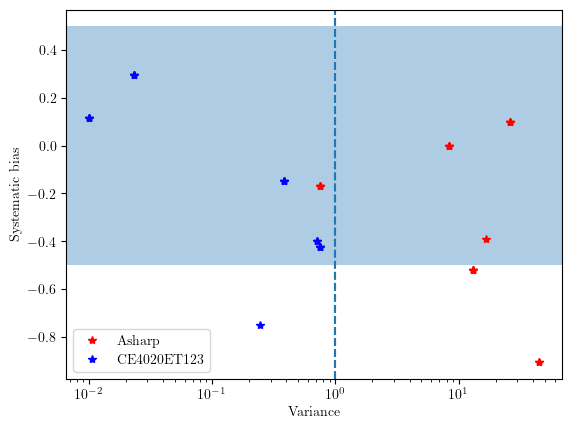

In [65]:
for netw, colr in zip(gwpop_samples['MD'].keys(),  ['r', 'b']):
    z_peak_new_bias = []
    variance = []
    for MDmodel in gwpop_samples.keys():
        for pop in gwpop_samples[MDmodel][netw].keys():
            c5 = np.percentile(gwpop_samples[MDmodel][netw][pop]['z_peak_new'], 5)
            c50 = np.percentile(gwpop_samples[MDmodel][netw][pop]['z_peak_new'], 50)
            c95 = np.percentile(gwpop_samples[MDmodel][netw][pop]['z_peak_new'], 95)
            stat_err = c95-c5
            bias = (c50-true_params[MDmodel]['z_peak_new'])/stat_err
            z_peak_new_bias.append(bias)
            if bias > 0.5 or bias < -0.5:
                print(netw, MDmodel, pop, ':', bias)
            variance.append(np.median(gwpop_full_posterior[MDmodel][netw][pop]['variance']))
        if MDmodel == 'MD':
            label = netw
        else:
            label = None
        plt.plot(variance, z_peak_new_bias, '*', c=colr, label=label)
    plt.axhspan(-0.5, 0.5, alpha=0.2)
    plt.axvline(1, ls='--')
    plt.legend()
    plt.xscale('log')
    plt.xlabel('Variance')
    plt.ylabel('Systematic bias')

# Plot the original population

## Load data

In [14]:
input_pop_snrs = {}
load_keys = []
for netw in netws:
    input_pop_snrs[netw] = {'total':{}}
    file_name = glob(os.path.join(project_dir, 'SNR_output_files_XPHM', 'BBH', f'*{netws[netw]}*.h5'))[0]
    with h5py.File(file_name, 'r') as f:
        for key in f['results'].keys():
            if 'SNR' in key or key in ['redshift', 'mtotal']:
                input_pop_snrs[netw]['total'][key] = f['results'][key][()]
    input_pop_snrs[netw]['total'] = pd.DataFrame(input_pop_snrs[netw]['total'])

## Define functions

In [15]:
def get_detected_SNRs(data_dict, ifo_threshold=5, network_threshold=12, 
                      method='network', return_detected_dict=False, 
                      snr_type='mf_from_opt'):
    if type(data_dict) == pd.core.frame.DataFrame:
        pass
    else:
        data_dict = pd.DataFrame(data_dict)
        
    if snr_type == 'opt':
        SNR_keys = [key for key in data_dict.keys() if 'SNR' in key and 'mf' not in key]
    elif snr_type == 'mf_from_opt':
        SNR_keys = [key for key in data_dict.keys() if 'SNR_mf_from_opt' in key]
    elif snr_type == 'mf':
        SNR_keys = [key for key in data_dict.keys() if 'SNR_mf' in key and 'from_opt' not in key]
    else:
        raise KeyError('Please choose snr_type from "opt" or "mf"')
    print(SNR_keys)
    detected_bool_dict = {}
    detected_dict = {}
    
    for key in SNR_keys:
        if snr_type == 'opt':
            dict_key = key.split('SNR_')[-1]
        elif snr_type == 'mf_from_opt':
            dict_key = key.split('SNR_mf_from_opt_')[-1]
        elif snr_type == 'mf':
            dict_key = key.split('SNR_mf_')[-1]
        
        if "network" in key:
            threshold = network_threshold
        else:
            threshold = ifo_threshold

        detected_bool_dict[dict_key] = data_dict[key] >= threshold
        detected_dict[dict_key] = data_dict[detected_bool_dict[dict_key]]

    if method=='all':
        detected_events_df = data_dict[np.all(tuple(detected_bool_dict.values()), axis=0) & detected_bool_dict['network']]
    elif method == 'two-detector':
        detector_keys = [key for key in detected_bool_dict.keys() if key != 'network']
        detection_sum = np.sum([detected_bool_dict[key] for key in detector_keys], axis=0)
        detected_events_df = data_dict[(detection_sum >= 2) & (detected_bool_dict['network'])]
    elif method=='network':
        detected_events_df = detected_dict['network']

    if return_detected_dict:
        return(detected_events_df, detected_dict)
    else:
        return(detected_events_df)

In [16]:
def plot_efficiency_curve(selected_data, total_data, bins='sqrt', **kwargs):
    ns_sel, bins_sel = np.histogram(selected_data, bins=bins)
    ns_tot, bins_tot = np.histogram(total_data, bins=bins_sel)
    if not np.all(bins_sel == bins_tot):
        raise ValueError("Bins are not equal! Something went wrong.")
    eff_samples = ns_sel/ns_tot
    #plt.bar(bins_sel[:-1], eff_samples, np.diff(bins_sel), **kwargs)
    
    # Using plt.step to create a step-like plot
    line = plt.stairs(eff_samples, bins_sel, **kwargs)
    return(eff_samples, bins_sel)

In [17]:
def slice_mtotal_pop(arr, mtotal_range):
    """
    Returns: A bool array corresponding to arr, depending on the range provided
    """
    if '<' in mtotal_range:
        max_boundary = float(mtotal_range.split('<')[-1])
        return(arr < max_boundary)
        
    elif '<=' in mtotal_range:
        max_boundary = float(mtotal_range.split('<=')[-1])
        return(arr <= max_boundary)
        
    elif '>' in mtotal_range:
        min_boundary = float(mtotal_range.split('>')[-1])
        return(arr > min_boundary)
        
    elif '>=' in mtotal_range:
        min_boundary = float(mtotal_range.split('>=')[-1])
        return(arr >= min_boundary)
        
    elif '-' in mtotal_range:
        min_boundary, max_boundary = map(float, mtotal_range.split('-'))
        return(np.all((arr >= min_boundary, arr <= max_boundary), axis=0))

## Create plots

### Get detected population

In [18]:
for netw in netws:
    input_pop_snrs[netw]['detected'] = get_detected_SNRs(input_pop_snrs[netw]['total'])

['SNR_mf_from_opt_H1', 'SNR_mf_from_opt_I1', 'SNR_mf_from_opt_L1', 'SNR_mf_from_opt_network']
['SNR_mf_from_opt_C1', 'SNR_mf_from_opt_CE20', 'SNR_mf_from_opt_E1', 'SNR_mf_from_opt_E2', 'SNR_mf_from_opt_E3', 'SNR_mf_from_opt_network']


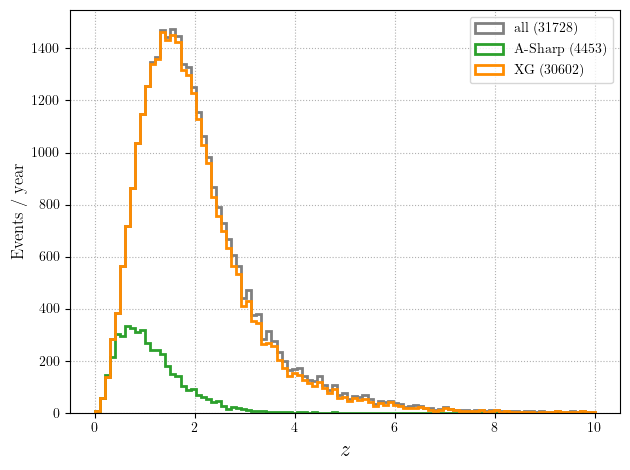

In [19]:
bins = np.linspace(0,10,100)
plt.hist(input_pop_snrs['XG']['total']['redshift'], histtype=u'step', label=f"all ({len(input_pop_snrs['XG']['total']['redshift'])})", 
         bins=bins, linewidth=2, color='grey')
plt.hist(input_pop_snrs['A-Sharp']['detected']['redshift'], histtype=u'step', color='tab:green', 
         label=f"A-Sharp ({len(input_pop_snrs['A-Sharp']['detected']['redshift'])})", bins=bins, linewidth=2)
plt.hist(input_pop_snrs['XG']['detected']['redshift'], histtype=u'step', color='darkorange',
         label=f"XG ({len(input_pop_snrs['XG']['detected']['redshift'])})", bins=bins, linewidth=2)
plt.legend()
plt.grid(ls=':')
plt.xlabel('$z$', fontsize=16)
plt.ylabel('Events / year', fontsize=12)
plt.tight_layout()
#plt.savefig(os.path.join(plot_dir, 'hist_z_events_detected_Asharp_XG_all.png'), dpi=300)

/tmp/ipykernel_8022/1059002197.py:6: RuntimeWarning: invalid value encountered in divide
  eff_samples = ns_sel/ns_tot


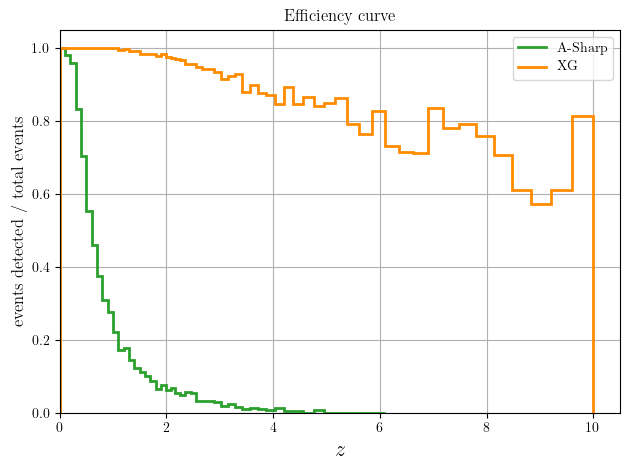

In [20]:
bins = np.concatenate([np.arange(0,2,0.1), np.logspace(np.log10(2),1,40)])
for netw, colr in zip(netws, ['tab:green', 'darkorange']):
    plot_efficiency_curve(input_pop_snrs[netw]['detected']['redshift'], input_pop_snrs[netw]['total']['redshift'], 
                          bins=bins, zorder=2, linewidth=2, label=netw, color=colr)
#plt.legend()
plt.ylim(0,)
plt.xlim(0,)
plt.xlabel('$z$', fontsize=16)
plt.ylabel('events detected / total events', fontsize=12)
plt.grid()
plt.title('Efficiency curve')
plt.legend()
plt.tight_layout()
#plt.savefig(os.path.join(plot_dir, 'efficiency_curve_Asharp_XG.png'), dpi=300)

### Plot mass bands

In [21]:
mass_ranges = ['<40', '40-80', '>80']
for netw in netws:
    input_pop_snrs[netw]['detected_mass_bands'] = {}
    for m_range in mass_ranges:
        m_bool_slice = slice_mtotal_pop(input_pop_snrs[netw]['detected']['mtotal'], m_range)
        input_pop_snrs[netw]['detected_mass_bands'][m_range] = input_pop_snrs[netw]['detected'][m_bool_slice]

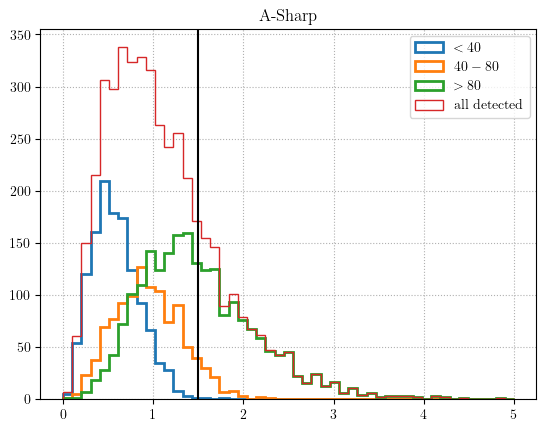

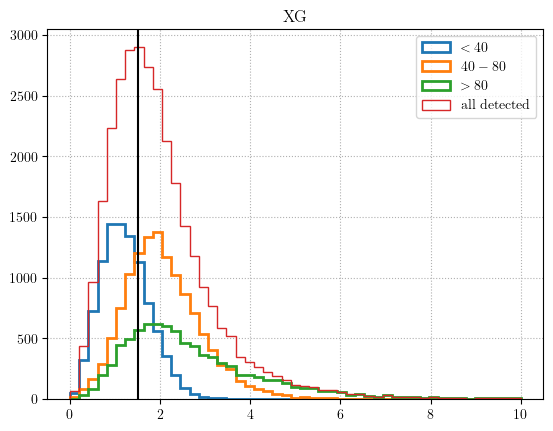

In [22]:
for netw, z_max in zip(netws, [5, 10]):
    bins = np.linspace(0, z_max, 50)
    plt.figure()
    for m_range in mass_ranges:
        plt.hist(input_pop_snrs[netw]['detected_mass_bands'][m_range]['redshift'], label=rf'${m_range}$', histtype=u'step', bins=bins, lw=2)
    plt.hist(input_pop_snrs[netw]['detected']['redshift'], label='all detected', bins=bins, histtype=u'step')
    plt.legend()
    plt.grid(ls=':')
    plt.title(netw)
    plt.axvline(1.5, c='k')

In [23]:
input_pop_snrs['A-Sharp']['detected_mass_bands']['<40'][input_pop_snrs['A-Sharp']['detected_mass_bands']['<40']['redshift'] > 1.5]

,SNR_H1,SNR_I1,SNR_L1,SNR_mf_H1,SNR_mf_I1,SNR_mf_L1,SNR_mf_from_opt_H1,SNR_mf_from_opt_I1,SNR_mf_from_opt_L1,SNR_mf_from_opt_network,SNR_mf_network,SNR_network,mtotal,redshift
5286,5.822008,6.476510,7.361303,6.206060,6.238526,6.624662,5.449193,6.614463,8.922154,12.371324,11.014559,11.403058,37.380890,1.514921
20261,6.058621,5.700144,7.165186,6.535132,4.935298,6.929657,9.077006,5.107229,6.517842,12.286501,10.727781,10.979000,39.811324,1.569824
22984,2.947685,6.294068,3.729957,5.039859,6.278103,5.255947,5.540528,9.920445,5.898686,12.802623,9.614559,7.887758,37.275931,1.817797


# SNR distribution

## Load FM errors

In [7]:
def decode_data(data):
    """
    Decodes byte strings or arrays of byte strings from HDF5.
    """
    if isinstance(data, bytes):
        return data.decode('utf-8')
    elif isinstance(data, np.ndarray) and data.dtype.kind in {'S', 'O'}:
        return [d.decode('utf-8') if isinstance(d, bytes) else d for d in data]
    else:
        return data

def load_from_h5_group(group):
    """
    Recursively loads data from an HDF5 group and reconstructs Python objects.
    """
    result = {}

    # Check if this group is an array-style list (all keys are numeric)
    keys = list(group.keys())
    if all(k.isdigit() for k in keys):
        # Treat it as a list, sorted by numeric key
        items = []
        for key in sorted(keys, key=lambda x: int(x)):
            val = group[key]
            if isinstance(val, h5py.Group):
                items.append(load_from_h5_group(val))
            else:
                items.append(decode_data(val[()]))
        return items

    # Otherwise treat as dict
    for key in group:
        item = group[key]
        if isinstance(item, h5py.Group):
            result[key] = load_from_h5_group(item)
        else:
            result[key] = decode_data(item[()])

    return result

def load_results_from_h5(filename):
    """
    Loads structured data from a universally saved HDF5 file.
    """
    with h5py.File(filename, 'r') as f:
        return load_from_h5_group(f)

In [8]:
fm_results = {}
for unique_key, netw in zip(['5945', '5999'], netws):
    print(netw)
    file_name = glob(os.path.join(project_dir, 'GWFish_analysis', 'BBH', 'Errors', 
                                  f'*{netws[netw]}*{unique_key}*XPHM_det10.h5'))
    print(file_name)
    fm_results[netw] = load_results_from_h5(file_name[0])

A-Sharp
['/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Errors/LHI_Asharp_2_PLP_z_MD_zmax_10_lmrd_22_no_spins_5945_events_365_days_pop_from_XPHM_det10.h5']
XG
['/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Errors/CE4020ET123_CoBA10_2_PLP_z_MD_zmax_10_lmrd_22_no_spins_5999_events_pop_from_XPHM_det10.h5']


In [12]:
for netw in fm_results.keys():
    for key,val in fm_results[netw].items():
        if type(val) == dict:
            fm_results[netw][key] = pd.DataFrame(fm_results[netw][key])

In [13]:
fm_results['XG']['all_inj_params_original']

,PSD_C1,PSD_CE20,PSD_E1,PSD_E2,PSD_E3,SNR_C1,SNR_CE20,SNR_E1,SNR_E2,SNR_E3,...,spin2x,spin2y,spin2z,srcmass1,srcmass2,srcmchirp,srcmtotal,theta_jn,time_interval,trigger_time
0,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,30.320871,15.118600,2.460759,5.403854,5.746864,...,-0.067550,0.281654,-0.524459,17.474277,7.433436,9.747349,24.907713,1.735659,872.338692,1.922562e+09
1,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,47.826077,43.067268,14.984925,20.119137,24.494942,...,0.453655,-0.533107,-0.621682,10.872589,7.281635,7.715100,18.154224,0.489261,699.808173,1.920531e+09
2,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,42.831538,14.442532,24.467666,24.412261,24.652342,...,0.003801,0.509486,0.093519,18.378830,10.635340,12.081463,29.014171,2.470606,2442.650410,1.902957e+09
3,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,87.600557,24.604260,36.252830,35.421185,38.333585,...,0.032395,-0.004563,-0.043217,28.870005,27.603125,24.573934,56.473130,1.092011,36.623670,1.922929e+09
4,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,31.659673,9.205945,6.146092,5.081365,10.625935,...,-0.588814,-0.417981,-0.307393,33.056424,22.086450,23.427783,55.142874,1.543129,1156.461945,1.908814e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5994,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,16.467351,8.715151,2.497899,0.528334,2.485631,...,-0.423810,-0.128730,-0.603991,9.383930,3.087855,4.550292,12.471785,1.987822,371.965075,1.920596e+09
5995,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,26.798924,21.937982,1.383749,7.885755,7.203524,...,-0.306997,0.073583,0.342890,10.891301,7.053404,7.594512,17.944705,0.530751,972.323647,1.920078e+09
5996,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,58.810171,19.079332,68.940010,68.814221,68.626805,...,-0.600831,0.187120,-0.209895,17.725127,14.600438,13.991489,32.325565,2.867502,602.209512,1.918901e+09
5997,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,18.250391,12.838903,17.755348,17.551522,18.482518,...,0.016743,0.563910,-0.003879,11.245475,8.628452,8.560314,19.873928,2.317722,2306.474320,1.909377e+09


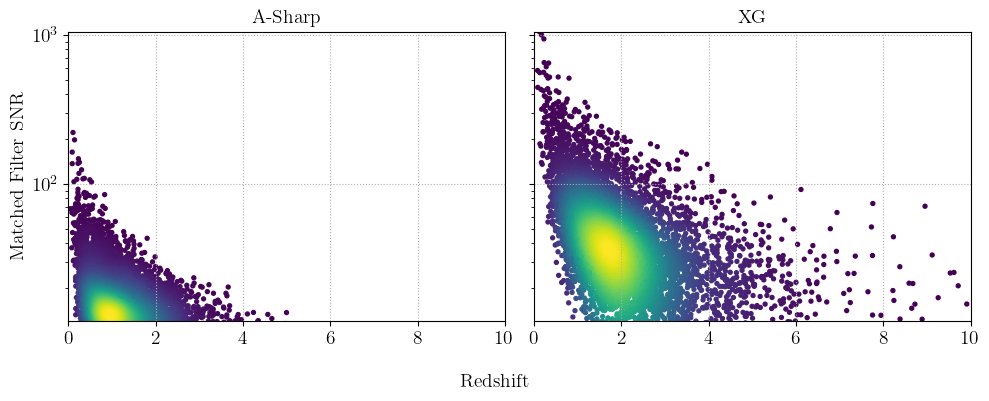

In [14]:
from scipy.stats import gaussian_kde

fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=True)
for i, netw in enumerate(netws):
    df = fm_results[netw]['all_inj_params_original']
    x = df['redshift'].values
    y = df['SNR_mf_from_opt_network'].values

    # Stack and compute 2D point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort to plot densest points on top
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    # Scatter with density as color
    sc = axs[i].scatter(x, y, c=z, s=8, cmap='viridis')
    axs[i].set_yscale('log')
    axs[i].set_title(netw, fontsize=14)
    axs[i].grid(ls=':')
    axs[i].set_ylim(12,1050)
    axs[i].set_xlim(0,10)
    axs[i].tick_params(labelsize=14)
fig.supxlabel('Redshift', fontsize=14)
axs[0].set_ylabel('Matched Filter SNR', fontsize=14)
#axs[1].tick_params(labelleft=True)
plt.tight_layout()
#plt.savefig(os.path.join(plot_dir, 'scatter_snr_vs_z_asharp_xg.png'), dpi=300)

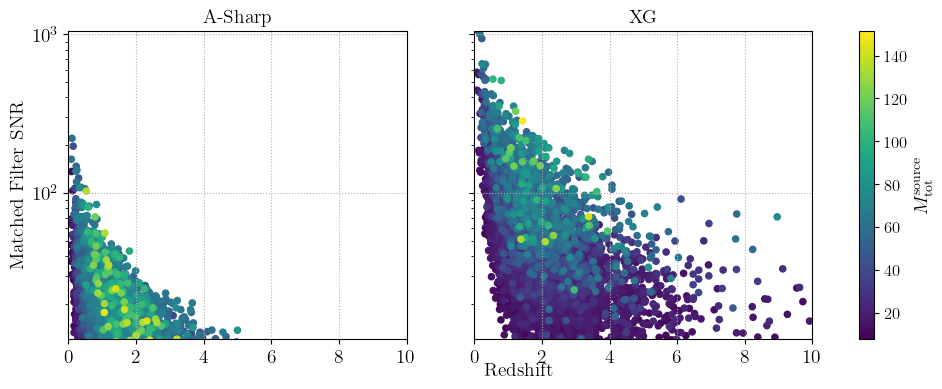

In [38]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for i, netw in enumerate(netws):
    df = fm_results[netw]['all_inj_params_original']
    x = df['redshift'].values
    y = df['SNR_mf_from_opt_network'].values
    z = df['srcmtotal'].values

    # Sort to plot densest points on top
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    # Scatter with density as color
    sc = axs[i].scatter(x, y, c=z, s=20, cmap='viridis')
    axs[i].set_yscale('log')
    axs[i].set_title(netw, fontsize=14)
    axs[i].grid(ls=':')
    axs[i].set_ylim(12, 1050)
    axs[i].set_xlim(0, 10)
    axs[i].tick_params(labelsize=14)
    #axs[i].set_xlim(0.7, 2.3)
    #axs[i].set_ylim(200, 400)

fig.supxlabel('Redshift', fontsize=14)
axs[0].set_ylabel('Matched Filter SNR', fontsize=14)

# Add a colorbar
cbar = fig.colorbar(sc, ax=axs, orientation='vertical')
cbar.set_label('$M_{\\mathrm{tot}}^{\\text{source}}$', fontsize=14)
cbar.ax.tick_params(labelsize=12)

#plt.tight_layout()

In [31]:
import pycbc.conversions as convert

In [33]:
convert.mchirp_from_mass1_mass2(30, 20)

21.237175175898688

# $\Delta z$ as a function of $z$

In [186]:
z_posterior_files = {'A-Sharp': os.path.join(project_dir, 'gwpopulation', 'BBH', 'LHI_Asharp_1_PLP_z_MD_zmax_6_lmrd_22_no_spins_all_events_365_days_z_posteriors_original_cov_4339_events_pop_from_XPHM.pkl'), 
                     'XG': os.path.join(project_dir, 'gwpopulation', 'BBH', 'CE4020ET123_CoBA10_2_PLP_z_MD_zmax_10_lmrd_22_no_spins_set3_z_posteriors_original_cov_4344_events_pop_from_XPHM.pkl')}

In [187]:
z_pos_all_events = {}
for netw in z_posterior_files.keys():
    z_pos_all_events[netw] = {'posteriors': pd.read_pickle(z_posterior_files[netw])}

In [188]:
def calc_5th_perc(arr):
    return(np.quantile(arr, 0.05))
def calc_95th_perc(arr):
    return(np.quantile(arr, 0.95))

In [189]:
for netw in netws:
    num_events = len(z_pos_all_events[netw]['posteriors'])
    z_pos_all_events[netw]['medians'] = np.array([np.median(z_pos_all_events[netw]['posteriors'][event]['redshift']) for event in range(num_events)])
    z_pos_all_events[netw]['5th_perc'] = np.array([np.quantile(z_pos_all_events[netw]['posteriors'][event]['redshift'], 0.05) for event in range(num_events)])
    z_pos_all_events[netw]['95th_perc'] = np.array([np.quantile(z_pos_all_events[netw]['posteriors'][event]['redshift'], 0.95) for event in range(num_events)])
    z_pos_all_events[netw]['error_intervals'] = z_pos_all_events[netw]['95th_perc'] - z_pos_all_events[netw]['5th_perc']

In [190]:
z_pos_all_events_df = {}
for netw in netws:
    z_pos_all_events_df[netw] = pd.DataFrame(z_pos_all_events[netw])
    z_pos_all_events_df[netw].sort_values('medians', ignore_index=True, inplace=True)
z_pos_all_events_df['A-Sharp']

,posteriors,medians,5th_perc,95th_perc,error_intervals
0,redshift prior 0 0.050205 0.0002 ...,0.049814,0.049407,0.050214,0.000806
1,redshift prior 0 0.075221 0.000...,0.069014,0.057879,0.080874,0.022995
2,redshift prior 0 0.069570 0.000...,0.069191,0.062993,0.075888,0.012894
3,redshift prior 0 0.065882 0.000...,0.075368,0.056611,0.098632,0.042021
4,redshift prior 0 0.079890 0.000...,0.086489,0.054963,0.178900,0.123937
...,...,...,...,...,...
4334,redshift prior 0 4.691420 0.000...,4.393853,2.992471,5.622842,2.630371
4335,redshift prior 0 4.648289 0.000...,4.396853,3.182156,5.722724,2.540568
4336,redshift prior 0 10.338102 0.0...,4.734765,1.780438,10.191009,8.410571
4337,redshift prior 0 4.392387 0.000...,5.625181,3.537529,7.879156,4.341627


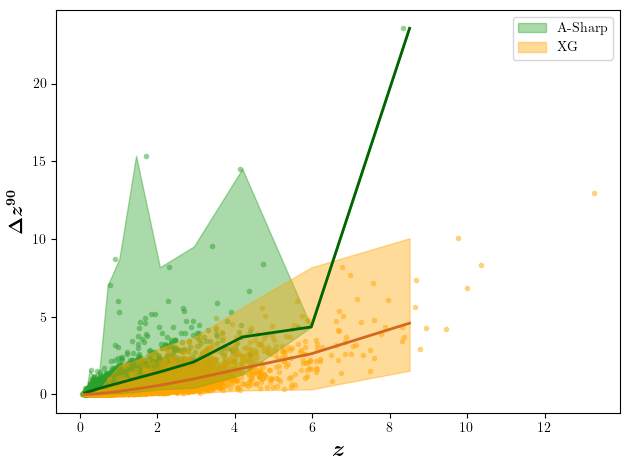

In [196]:
#bins = np.arange(0,10,0.9)
bins = np.logspace(-1, 1, 14)
for netw, colr, lc in zip(netws, ['tab:green', 'orange'], ['darkgreen', 'chocolate']):
    means, edges, binnums = binned_statistic(z_pos_all_events_df[netw]['medians'], z_pos_all_events_df[netw]['error_intervals'], bins=bins)
    maxs, edges, binnums = binned_statistic(z_pos_all_events_df[netw]['medians'], z_pos_all_events_df[netw]['error_intervals'], bins=bins, statistic='max')
    mins, edges, binnums = binned_statistic(z_pos_all_events_df[netw]['medians'], z_pos_all_events_df[netw]['error_intervals'], bins=bins, statistic='min')
    
    #mins = [0] + list(mins)
    #maxs = [0] + list(maxs)
    #means = [0] + list(means)
    #edges_midpts = [0] + list((edges[:-1] + edges[1:])/2)
    edges_midpts = list((edges[:-1] + edges[1:])/2)
    
    plt.plot(z_pos_all_events_df[netw]['medians'], z_pos_all_events_df[netw]['error_intervals'], '.', c=colr, alpha=0.5, zorder=0, mew=0, ms=8)
    plt.plot(edges_midpts, means, c=lc, lw=2)
    plt.fill_between(edges_midpts, mins, maxs, alpha=0.4, color=colr, label=netw)
plt.legend()
plt.xlabel(r'$\boldsymbol{z}$', fontsize=16, fontweight='bold')
plt.ylabel(r'$\boldsymbol{\Delta z^{90}}$', fontsize=14, fontweight='bold')
plt.tight_layout()
#plt.savefig(os.path.join(plot_dir, 'deltaz90_from_posteriors_vs_z_median_asharp_xg_max_min_mean_bands.png'), dpi=300)

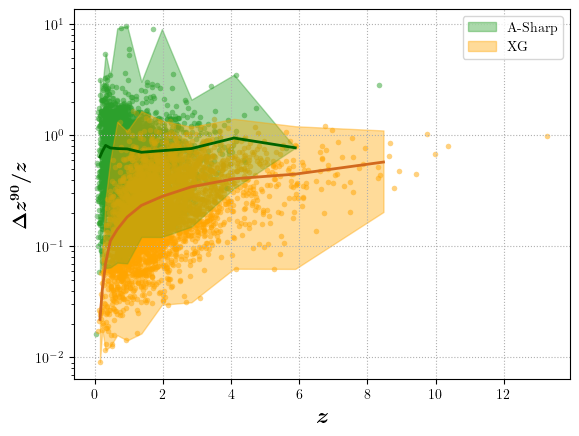

In [210]:
#bins = np.array([0, 0.1] + list(np.arange(0.2,10,0.9)))
bins = np.logspace(-0.9, 1, 13)
for netw, colr, lc in zip(netws, ['tab:green', 'orange'], ['darkgreen', 'chocolate']):
    means, edges, binnums = binned_statistic(z_pos_all_events_df[netw]['medians'], z_pos_all_events_df[netw]['error_intervals']/z_pos_all_events_df[netw]['medians'], bins=bins)
    maxs, edges, binnums = binned_statistic(z_pos_all_events_df[netw]['medians'], z_pos_all_events_df[netw]['error_intervals']/z_pos_all_events_df[netw]['medians'], bins=bins, statistic='max')
    mins, edges, binnums = binned_statistic(z_pos_all_events_df[netw]['medians'], z_pos_all_events_df[netw]['error_intervals']/z_pos_all_events_df[netw]['medians'], bins=bins, statistic='min')
    
    edges_midpts = list((edges[:-1] + edges[1:])/2)
    
    plt.plot(z_pos_all_events_df[netw]['medians'], z_pos_all_events_df[netw]['error_intervals']/z_pos_all_events_df[netw]['medians'], '.', c=colr, alpha=0.5, zorder=0, mew=0, ms=8)
    if netw == 'A-Sharp':
        plt.plot(edges_midpts[:-1], means[:-1], c=lc, lw=2)
        plt.fill_between(edges_midpts[:-1], mins[:-1], maxs[:-1], alpha=0.4, color=colr, label=netw)
    else:
        plt.plot(edges_midpts, means, c=lc, lw=2)
        plt.fill_between(edges_midpts, mins, maxs, alpha=0.4, color=colr, label=netw)
plt.legend()
plt.xlabel(r'$\boldsymbol{z}$', fontsize=16, fontweight='bold')
plt.ylabel(r'$\boldsymbol{\Delta z^{90}/z}$', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.grid(ls=':')
plt.savefig(os.path.join(plot_dir, 'deltaz90_by_z_from_posteriors_vs_z_median_asharp_xg_max_min_mean_bands.png'), dpi=300)

In [9]:
import bilby

In [20]:
pop_res_files_tot = {}
for MDmodel in gwpop_run_dirs.keys():
    pop_res_files_tot[MDmodel] = {netw:os.path.join(gwpop_run_dirs[MDmodel][netw]['total'], f'{netw}_result.hdf5') for netw in gwpop_run_dirs[MDmodel].keys()}

In [21]:
pop_res_files_tot

{'MD': {'Asharp': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/gwpop_analysis_results/Asharp/run05_gwfish_mf_from_opt_SNR_injections_XPHM/Asharp_result.hdf5',
  'CE4020ET123': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/gwpop_analysis_results/CE4020ET123/run13_gwfish_mf_from_opt_SNR_injections_XPHM/CE4020ET123_result.hdf5'},
 'MDhigh': {'Asharp': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/gwpop_analysis_results/Asharp/run06_gwfish_MDhigh_mf_from_opt_SNR_injections_XPHM/Asharp_result.hdf5',
  'CE4020ET123': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/gwpop_analysis_results/CE4020ET123/run14_gwfish_MDhigh_mf_from_opt_SNR_injections_XPHM/CE4020ET123_result.hdf5'},
 'MDlow': {'Asharp': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_Unive

In [11]:
pop_results = {}
for netw, key in zip(netws, pop_res_files.keys()):
    pop_results[netw] = bilby.result.read_in_result(filename=pop_res_files[key])

In [12]:
pop_results['A-Sharp'].posterior

,gamma,kappa,log_likelihood,log_prior,z_peak
0,0.737553,9.143169,39820.564930,-5.857933,2.624692
1,1.016989,5.932853,39821.618329,-5.857933,2.500436
2,1.018467,10.261522,39822.538438,-5.857933,2.455334
3,0.803057,7.865697,39822.602658,-5.857933,2.504720
4,0.992458,6.105319,39822.656353,-5.857933,2.502059
...,...,...,...,...,...
3270,1.349354,6.224638,39830.070558,-5.857933,2.087231
3271,1.330103,6.165955,39830.072655,-5.857933,2.103562
3272,1.315115,6.284310,39830.074259,-5.857933,2.112818
3273,1.318506,6.315495,39830.075344,-5.857933,2.113989


## Add the new parameter which is peak of the curve

In [13]:
for netw in netws:
    pop_results[netw].posterior.loc[:, 'z_peak_new'] = z_peak_new(pop_results[netw].posterior['gamma'], 
                                                                  pop_results[netw].posterior['kappa'], 
                                                                  pop_results[netw].posterior['z_peak'])

In [14]:
pop_results['A-Sharp'].posterior

,gamma,kappa,log_likelihood,log_prior,z_peak,z_peak_new
0,0.737553,9.143169,39820.564930,-5.857933,2.624692,1.777731
1,1.016989,5.932853,39821.618329,-5.857933,2.500436,1.684009
2,1.018467,10.261522,39822.538438,-5.857933,2.455334,1.787048
3,0.803057,7.865697,39822.602658,-5.857933,2.504720,1.658340
4,0.992458,6.105319,39822.656353,-5.857933,2.502059,1.677391
...,...,...,...,...,...,...
3270,1.349354,6.224638,39830.070558,-5.857933,2.087231,1.511572
3271,1.330103,6.165955,39830.072655,-5.857933,2.103562,1.517352
3272,1.315115,6.284310,39830.074259,-5.857933,2.112818,1.519338
3273,1.318506,6.315495,39830.075344,-5.857933,2.113989,1.521721


### Add priors

In [15]:
prior_dict = bilby.prior.PriorDict(dictionary=pop_results['XG'].priors, conversion_function=z_peak_new_from_dict)
prior_dict['z_peak_new'] = bilby.prior.Constraint(minimum=0, maximum=10, latex_label='$\\tilde{z}_p$')
prior_dict

{'gamma': Uniform(minimum=0, maximum=5, name=None, latex_label='$\\gamma$', unit=None, boundary=None),
 'kappa': Uniform(minimum=0, maximum=20, name=None, latex_label='$\\kappa$', unit=None, boundary=None),
 'z_peak': Uniform(minimum=0.5, maximum=4, name=None, latex_label='$z_{peak}$', unit=None, boundary=None),
 'z_peak_new': Constraint(minimum=0, maximum=10, name=None, latex_label='$\\tilde{z}_p$', unit=None)}

In [16]:
prior_samples = {}
for netw in pop_results.keys():
    result = pop_results[netw]
    num_posterior_samples = len(result.samples)
    prior_samples[netw] = prior_dict.sample(num_posterior_samples)
    prior_samples[netw]['z_peak_new'] = z_peak_new(gamma=prior_samples[netw]['gamma'], 
                                                   kappa=prior_samples[netw]['kappa'], 
                                                   z_peak=prior_samples[netw]['z_peak'])

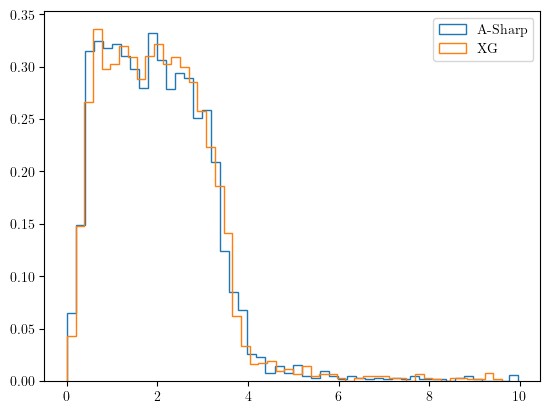

In [17]:
for netw in prior_samples.keys():
    plt.hist(prior_samples[netw]['z_peak_new'], bins=50, label=netw, histtype='step', density=True)
plt.legend()

/home/divyajyoti/miniconda3/envs/igwn-py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/divyajyoti/miniconda3/envs/igwn-py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/divyajyoti/miniconda3/envs/igwn-py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/divyajyoti/m

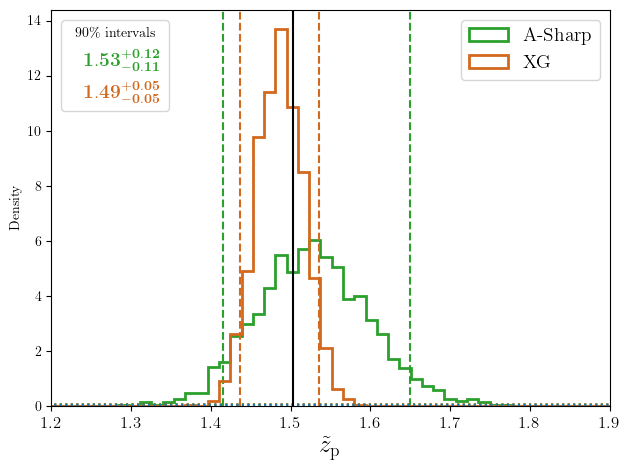

In [18]:
import matplotlib.lines as mlines

colors = ['tab:green', 'chocolate']
bins = np.linspace(1, 2.4, 100)
leg_text = []
for netw, colr in zip(netws, colors):
    histdata = pop_results[netw].posterior['z_peak_new']
    ci5 = np.quantile(histdata, 0.05)
    ci95 = np.quantile(histdata, 0.95)
    ci50 = np.median(histdata)
    
    plt.hist(histdata, label=netw, lw=2,
             density=True, histtype=u'step', bins=bins, color=colr)
    plt.axvline(ci5, c=colr, ls='--')
    plt.axvline(ci95, c=colr, ls='--')

    leg_text.append('$\mathbf{%s_{-%s}^{+%s}}$'%(round(ci50, 2), round(ci50-ci5, 2), round(ci95-ci50, 2)))
sns.kdeplot(prior_samples['A-Sharp'], color='grey', ls=':')

l1 = mlines.Line2D([], [], color=colors[0], label=leg_text[0])
l2 = mlines.Line2D([], [], color=colors[1], label=leg_text[1])

legend1 = plt.legend(handles=[l1,l2], handlelength=0, labelcolor='linecolor', 
                         title='90\% intervals', fontsize=14, loc=2)
plt.gca().add_artist(legend1)

plt.axvline(true_params['z_peak_new'], c='k')
plt.legend(fontsize=14)
plt.xlabel('$\\tilde{z}_{\mathrm{p}}$', fontsize=18)
plt.xlim(1.2, 1.9)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'posteriors_z_peak_new_Asharp_XG.png'), dpi=300)

# Posteriors for hyperparameters

## Load result files

In [44]:
import bilby
import os

In [45]:
pop_res_files = map_nested_dict(gwpop_run_dirs, find_file)

In [46]:
def bilby_read_result_with_new_param(file):
    bilby_result = bilby.result.read_in_result(filename=file)
    posterior = bilby_result.posterior
    bilby_result.posterior.loc[:, 'z_peak_new'] = z_peak_new(posterior['gamma'], posterior['kappa'], posterior['z_peak'])
    
    #drop nan
    bilby_result.posterior.dropna(inplace=True)
    
    # remove points with z_peak_new above 99 percentile to avoid outliers
    points_c99 = (bilby_result.posterior['z_peak_new'] < np.quantile(bilby_result.posterior['z_peak_new'], 0.99))
    points_positive = (bilby_result.posterior['z_peak_new'] > 0)
    bilby_result.posterior = bilby_result.posterior[points_c99 & points_positive]
    return(bilby_result)

In [47]:
pop_results = map_nested_dict(pop_res_files, bilby_read_result_with_new_param)

In [48]:
mass_bands = [key for key in gwpop_run_dirs['MD']['Asharp'].keys() if key != 'total']
mass_bands

['below_40', '40-80', 'above_80']

In [49]:
pop_results['MD']['CE4020ET123']['40-80'].posterior

,gamma,kappa,log_likelihood,log_prior,z_peak,z_peak_new
0,1.614521,6.870901,6487.425918,-5.857933,2.242436,1.730617
2,1.321474,4.530574,6489.219713,-5.857933,2.108426,1.555587
6,0.264571,4.691008,6490.012730,-5.857933,2.723981,1.042617
7,1.894581,6.106218,6490.037670,-5.857933,2.183194,1.792840
8,0.389977,4.669494,6490.216791,-5.857933,2.543049,1.121186
...,...,...,...,...,...,...
3223,1.152114,5.437748,6497.446047,-5.857933,2.317624,1.605606
3224,1.088985,5.408062,6497.447834,-5.857933,2.354928,1.600395
3225,1.090692,5.438762,6497.454010,-5.857933,2.342079,1.591721
3226,1.099121,5.430247,6497.455461,-5.857933,2.351959,1.603904


### Add priors

In [50]:
prior_dict = bilby.prior.PriorDict(dictionary=pop_results['MD']['CE4020ET123']['40-80'].priors, conversion_function=z_peak_new_from_dict)
prior_dict['z_peak_new'] = bilby.prior.Constraint(minimum=0, maximum=10, latex_label='$\\tilde{z}_p$')
prior_dict

{'gamma': Uniform(minimum=0, maximum=5, name=None, latex_label='$\\gamma$', unit=None, boundary=None),
 'kappa': Uniform(minimum=0, maximum=20, name=None, latex_label='$\\kappa$', unit=None, boundary=None),
 'z_peak': Uniform(minimum=0.5, maximum=4, name=None, latex_label='$z_{peak}$', unit=None, boundary=None),
 'z_peak_new': Constraint(minimum=0, maximum=10, name=None, latex_label='$\\tilde{z}_p$', unit=None)}

In [51]:
def build_prior_samples_from_bilby_result(result):
    num_posterior_samples = len(result.samples)
    prior_samples = prior_dict.sample(num_posterior_samples)
    prior_samples['z_peak_new'] = z_peak_new(gamma=prior_samples['gamma'], 
                                             kappa=prior_samples['kappa'], 
                                             z_peak=prior_samples['z_peak'])
    return(prior_samples)

In [52]:
prior_samples = map_nested_dict(pop_results, build_prior_samples_from_bilby_result)

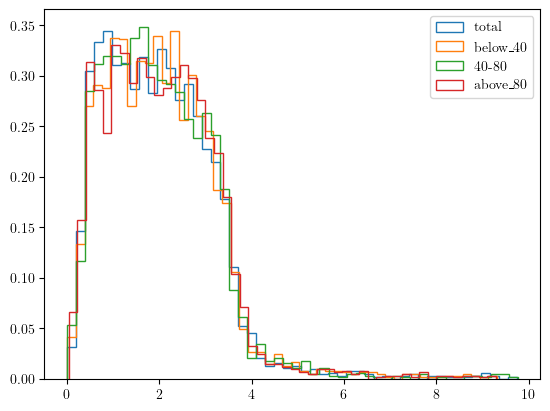

In [53]:
for m_range in prior_samples['MD']['Asharp'].keys():
    plt.hist(prior_samples['MD']['Asharp'][m_range]['z_peak_new'], bins=50, label=m_range, histtype='step', density=True)
plt.legend()

## Plot total population

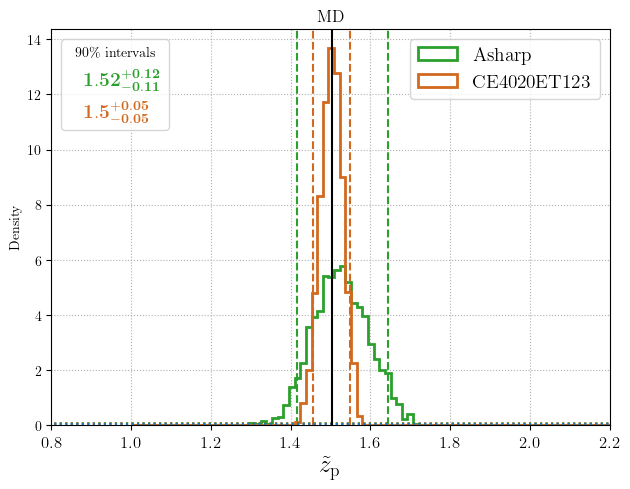

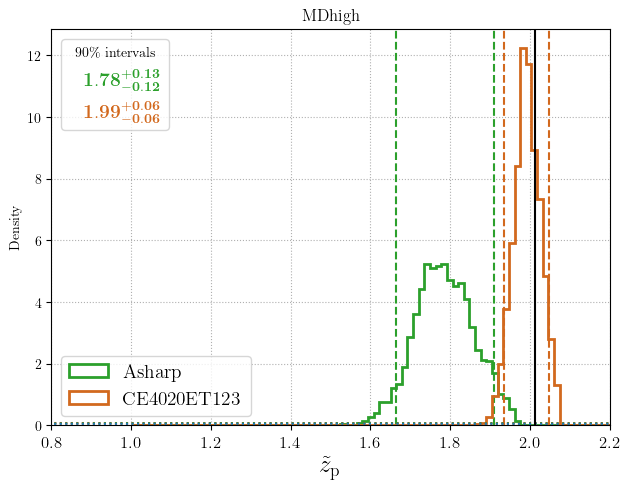

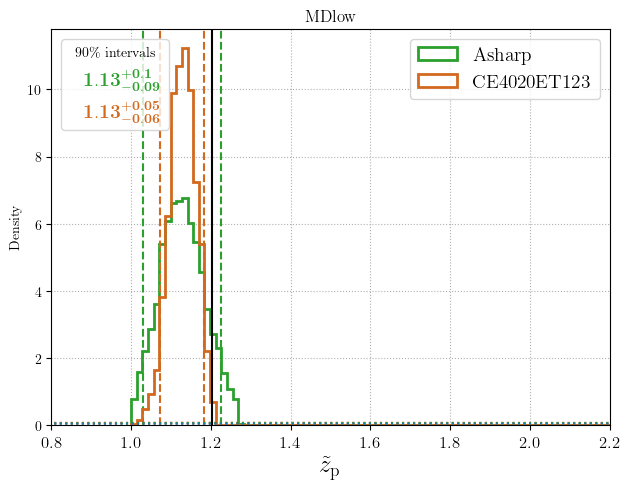

In [55]:
import matplotlib.lines as mlines
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

colors = ['tab:green', 'chocolate']
bins = np.linspace(1, 2.4, 100)
for MDmodel, loc in zip(pop_results.keys(), [1, 3, 1]):
    leg_text = []
    plt.figure()
    for netw, colr in zip(pop_results['MD'].keys(), colors):
        histdata = pop_results[MDmodel][netw]['total'].posterior['z_peak_new']
        ci5 = np.quantile(histdata, 0.05)
        ci95 = np.quantile(histdata, 0.95)
        ci50 = np.median(histdata)
        
        plt.hist(histdata, label=netw, lw=2,
                 density=True, histtype=u'step', bins=bins, color=colr)
        plt.axvline(ci5, c=colr, ls='--')
        plt.axvline(ci95, c=colr, ls='--')
    
        leg_text.append('$\mathbf{%s_{-%s}^{+%s}}$'%(round(ci50, 2), round(ci50-ci5, 2), round(ci95-ci50, 2)))
        plt.grid(ls=':')
    sns.kdeplot(prior_samples[MDmodel]['Asharp']['total'], color='grey', ls=':')
    
    l1 = mlines.Line2D([], [], color=colors[0], label=leg_text[0])
    l2 = mlines.Line2D([], [], color=colors[1], label=leg_text[1])
    
    legend1 = plt.legend(handles=[l1,l2], handlelength=0, labelcolor='linecolor', 
                             title='90\% intervals', fontsize=14, loc=2)
    plt.gca().add_artist(legend1)
    
    plt.axvline(true_params[MDmodel]['z_peak_new'], c='k')
    plt.legend(fontsize=14, loc=loc)
    plt.xlabel('$\\tilde{z}_{\mathrm{p}}$', fontsize=18)
    plt.xlim(0.8, 2.2)
    plt.xticks(fontsize=12)
    plt.tight_layout()
    plt.title(MDmodel)
    plt.savefig(os.path.join(plot_dir, f'posteriors_z_peak_new_Asharp_XG_{MDmodel}.png'), dpi=300)

### Plot posteriors for mass bands

In [56]:
m_range_labels = {key:key.replace('below_','$< $').replace('above_', '$> $') for key in mass_bands}
m_range_labels

{'below_40': '$< $40', '40-80': '40-80', 'above_80': '$> $80'}

<Figure size 640x480 with 0 Axes>

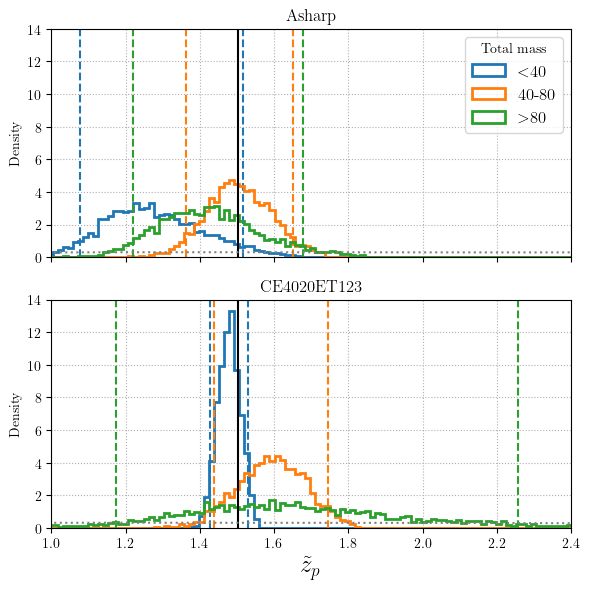

<Figure size 640x480 with 0 Axes>

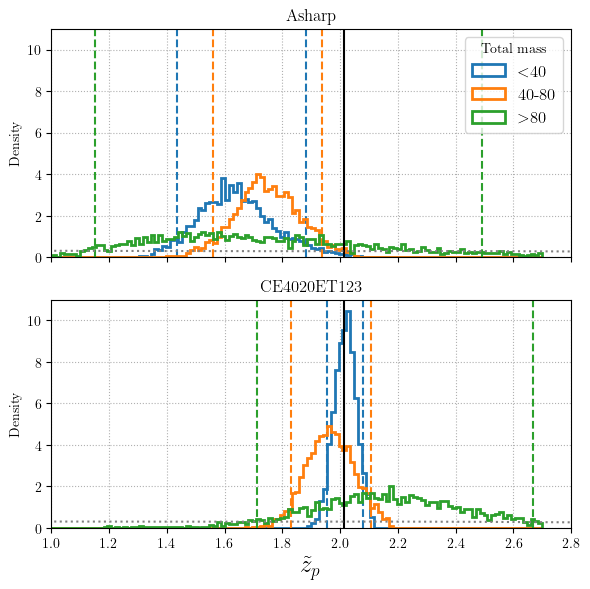

<Figure size 640x480 with 0 Axes>

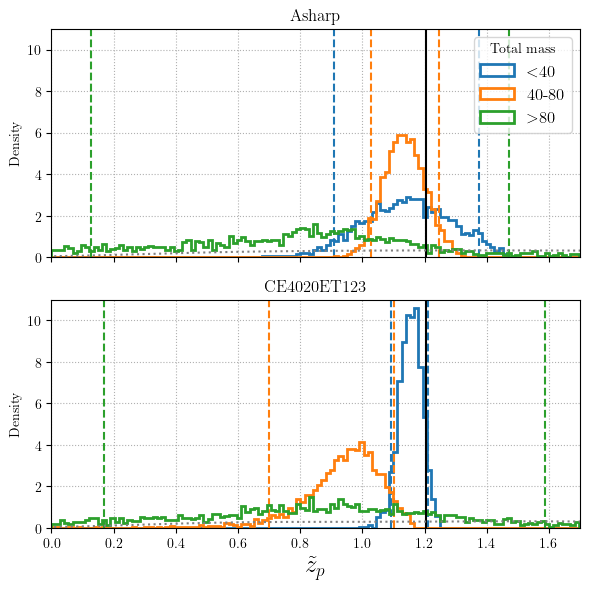

In [70]:
bins = np.linspace(0, 2.7, 200)
x_lims = {'MD':(1, 2.4),
          'MDhigh':(1, 2.8),
          'MDlow':(0.0, 1.7)}
for MDmodel, y_lim in zip(pop_results.keys(), [14, 11, 11]):
    plt.figure()
    fig, axs = plt.subplots(2,1, figsize=(6,6), sharex=True)
    for i, netw in enumerate(pop_results['MD'].keys()):
        for m_range in mass_bands:
            post_zp_new = pop_results[MDmodel][netw][m_range].posterior['z_peak_new']
            hist = axs[i].hist(post_zp_new, histtype=u'step', 
                               bins=bins, label=m_range_labels[m_range], density=True, lw=2)
            color = hist[2][0].get_edgecolor()
            ci5 = np.quantile(post_zp_new, 0.05)
            ci95 = np.quantile(post_zp_new, 0.95)
            axs[i].axvline(ci5, color=color, ls='--')
            axs[i].axvline(ci95, color=color, ls='--')
            
        axs[i].grid(ls=':')
        axs[i].set_title(netw)
        axs[i].axvline(true_params[MDmodel]['z_peak_new'], c='k')
        axs[i].set_xlim(x_lims[MDmodel][0], x_lims[MDmodel][1])
        axs[i].set_ylim(0, y_lim)
        sns.kdeplot(prior_samples[MDmodel][netw][m_range]['z_peak_new'], color='grey', ls=':', ax=axs[i])
    axs[0].legend(loc=1, title='Total mass', fontsize=12)
    axs[1].set_xlabel('$\\tilde{z}_p$', fontsize=18)
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, f'hist_zp_new_mass_bands_{MDmodel}.png'), dpi=300)

# Plot selection func and population

In [29]:
gwpop_run_dirs

{'MD': {'Asharp': {'total': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/gwpop_analysis_results/Asharp/run09_gwfish_mf_from_opt_SNR_injections_XPHM',
   'below_40': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/gwpop_analysis_results/Asharp/mass_bands/below_40/run03_gwfish_mf_from_opt_SNR_injections_XPHM',
   '40-80': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/gwpop_analysis_results/Asharp/mass_bands/40-80/run02_gwfish_mf_from_opt_SNR_injections_XPHM',
   'above_80': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/gwpop_analysis_results/Asharp/mass_bands/above_80/run04_gwfish_mf_from_opt_SNR_injections_XPHM'},
  'CE4020ET123': {'total': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulat

# Systems beyond a particular z

In [44]:
from glob import glob
mass_bands = ['below_40', '40-80', 'above_80']
event_files = glob('/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/posteriors_from_GWFish/mass_bands/LHI_Asharp_4_PLP_z_fref_10_MDhigh_zp_2.53_zmax_10_lmrd_22_no_spins_z_posteriors_10K_*_events_pop_from_XPHM_*.pkl')
event_files

['/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/posteriors_from_GWFish/mass_bands/LHI_Asharp_4_PLP_z_fref_10_MDhigh_zp_2.53_zmax_10_lmrd_22_no_spins_z_posteriors_10K_2088_events_pop_from_XPHM_below_40.pkl',
 '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/posteriors_from_GWFish/mass_bands/LHI_Asharp_4_PLP_z_fref_10_MDhigh_zp_2.53_zmax_10_lmrd_22_no_spins_z_posteriors_10K_2254_events_pop_from_XPHM_40-80.pkl',
 '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/posteriors_from_GWFish/mass_bands/LHI_Asharp_4_PLP_z_fref_10_MDhigh_zp_2.53_zmax_10_lmrd_22_no_spins_z_posteriors_10K_222_events_pop_from_XPHM_above_80.pkl']

In [45]:
event_files_dict = {}
for file in event_files:
    for m in mass_bands:
        if m in file:
            event_files_dict[m] = file
event_files_dict

{'below_40': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/posteriors_from_GWFish/mass_bands/LHI_Asharp_4_PLP_z_fref_10_MDhigh_zp_2.53_zmax_10_lmrd_22_no_spins_z_posteriors_10K_2088_events_pop_from_XPHM_below_40.pkl',
 '40-80': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/posteriors_from_GWFish/mass_bands/LHI_Asharp_4_PLP_z_fref_10_MDhigh_zp_2.53_zmax_10_lmrd_22_no_spins_z_posteriors_10K_2254_events_pop_from_XPHM_40-80.pkl',
 'above_80': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/posteriors_from_GWFish/mass_bands/LHI_Asharp_4_PLP_z_fref_10_MDhigh_zp_2.53_zmax_10_lmrd_22_no_spins_z_posteriors_10K_222_events_pop_from_XPHM_above_80.pkl'}

In [46]:
import dill
events = {}
for m in mass_bands:
    with open(event_files_dict[m], 'rb') as f:
        events[m] = dill.load(f)

In [47]:
import numpy as np
from tqdm import tqdm
z_medians = {}
for m in mass_bands:
    z_medians[m] = [np.median(event['redshift']) for event in tqdm(events[m])]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:00<00:00, 3757.91it/s]


In [48]:
import pylab as plt

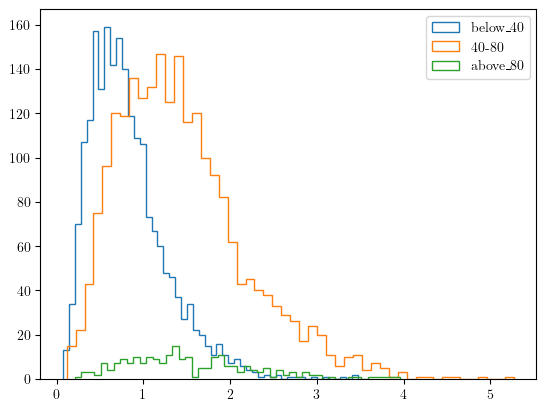

In [52]:
for m in mass_bands:
    plt.hist(z_medians[m], bins=50, label=m, histtype='step');
plt.legend()